In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import math

from utilities import *
from block_coordinate_functions import *

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

PyTorch Version: 1.11.0+cu113
Torchvision Version: 0.12.0+cu113
GPU is available? True


In [30]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Imported datasets
For the testing and comparison of our algorithms we will use the following datasets:

1. MNIST

In [31]:
ts = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
mnist_trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)

# Train - test split

Code taken from https://github.com/timlautk/BCD-for-DNNs-PyTorch/blob/master/bcd_dnn_mlp_mnist.ipynb

In [32]:
x_train, y_train, x_test, y_test = train_test_split(mnist_trainset, mnist_testset)

# we move to device to use GPU

x_train = x_train.to(device = device)
x_test = x_test.to(device = device)
y_train = y_train.to(device = device)
y_test = y_test.to(device = device)

# we perform one-hot encoding on the y-> y_one_hot will be a tensor of dimension 10*training_samples, for each sample there
# will be a one in the row corresponding to the class.

N = y_train.shape[0]
K = 10 # number of classes
y_one_hot = torch.zeros(N, K).to(device = device).scatter_(1, torch.reshape(y_train,(N,1)), 1)
y_one_hot = torch.t(y_one_hot).to(device=device)

N_test = y_test.shape[0]
y_test_one_hot = torch.zeros(N_test, K).to(device = device).scatter_(1, torch.reshape(y_test,(N_test,1)), 1)
y_test_one_hot = torch.t(y_test_one_hot).to(device=device)

# Architecture initialization

For the MultiLayerPerceptron we have the parameters **input_size** , **hidden_size**,**output_size** corresponding to the size of the input layer, the hidden layer and the output layer, respectively.

The MLP only has 3 layers like https://github.com/timlautk/BCD-for-DNNs-PyTorch/blob/master/bcd_dnn_mlp_mnist.ipynb as a starting point.

Also we use ReLU currently for the same reason.

In [33]:
input_size = 28*28
hidden_size = 1500
output_size = 10

In [34]:
torch.manual_seed(32)
d0 = input_size
d1 = d2 = 1500
d3 = output_size 

# The layers are: input + 2 hidden + output

# we represent the weigths of each layer as matrices with d_{i-1} columns and d_{i} rows

# Weight initialization (we replicate pytorch initialization)
std_1 = math.sqrt(1/d0)
W1 = torch.FloatTensor(d1, d0).uniform_(-std_1, std_1)
b1 = torch.FloatTensor(d1, 1).uniform_(-std_1, std_1)

# we move them to GPU
b1 = b1.to('cuda:0')
W1 = W1.to('cuda:0')


std_2 = math.sqrt(1/d1)
W2 = torch.FloatTensor(d2, d1).uniform_(-std_2, std_2)
b2 = torch.FloatTensor(d2, 1).uniform_(-std_2, std_2)

# we move them to GPU
b2 = b2.to('cuda:0')
W2 = W2.to('cuda:0')

std_3 = math.sqrt(1/d2)
W3 = torch.FloatTensor(d3, d2).uniform_(-std_3, std_3)
b3 = torch.FloatTensor(d3, 1).uniform_(-std_3, std_3)

# we move them to GPU
b3 = b3.to('cuda:0')
W3 = W3.to('cuda:0')


U1 = torch.addmm(b1.repeat(1, N), W1, x_train) # equivalent to W1@x_train+b1.repeat(1,N)
V1 = nn.ReLU()(U1)
U2 = torch.addmm(b2.repeat(1, N), W2, V1)
V2 = nn.ReLU()(U2)
U3 = torch.addmm(b3.repeat(1, N), W3, V2)
V3 = U3

# constant initializations
gamma = 1
gamma1 = gamma2 = gamma3 = gamma4 = gamma

rho = gamma
rho1 = rho2 = rho3 = rho4 = rho


alpha = 5
alpha1 = alpha2 = alpha3 = alpha4 = alpha5 = alpha6 = alpha7 \
= alpha8 = alpha9 = alpha10 = alpha

# initialization of the vectors of losses and accuracies
niter = 30
loss1 = np.empty(niter)
loss2 = np.empty(niter)
accuracy_train = np.empty(niter)
accuracy_test = np.empty(niter)
time1 = np.empty(niter)

In [35]:
def update_v_js(U1, U2, W, b, rho, gamma):
    """
    The function updates the V_js parameters during the training phase
    
    :param U1: The U parameter on the same level of V that we are updating
    :param U2: The U parameter which is in the next level of the V that we are updating
    :param W: The W parameter which is in the next level of the V that we are updating
    :param b: The b parameter which is in the next level of the V that we are updating
    :param rho: The constant rho parameter which is in the next level of the V that we are updating
    :param gamma: The constant gamma parameter which is in the next level of the V that we are updating
    :return: The updated V
    """
    _, d = W.size()
    I = torch.eye(d, device=device)
    U1 = nn.ReLU()(U1)
    _, col_U2 = U2.size()
    Vstar = torch.mm(torch.inverse(rho * (torch.mm(torch.t(W), W)) + gamma * I),
                     rho * torch.mm(torch.t(W), U2 - b.repeat(1, col_U2)) + gamma * U1)
    return Vstar


def update_wb_js(U, V, W, b, alpha, rho):
    """
    The function updates the W and b parameters during the training phase
    
    :param U: The U in the current level of W and b
    :param V: The V in the previous level with respect to the W that we are updating
    :param W: The current W that we have to update
    :param b: The current b that we have to update
    :param alpha: The alpha constant of the updates
    :param rho: The rho constant of the updates
    :return:
    """
    d, N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha * W + rho * torch.mm(U - b.repeat(1, col_U), torch.t(V)),
                     torch.inverse(alpha * I + rho * (torch.mm(V, torch.t(V)))))
    bstar = (alpha * b + rho * torch.sum(U - torch.mm(W, V), dim=1).reshape(b.size())) / (rho * N + alpha)
    return Wstar, bstar


def relu_prox(a, b, gamma, d, N):
    """
    The function compute the solution to the relu proximal update problem
    
    :param a: the a in the closed formula of the linearized update
    :param b: the b in the closed formula of the linearized update
    :param gamma: The constant used in the update
    :param d: the dimension of the current layer
    :param N: The number of samples
    :return: The obtained solution of the prox update
    """
    val = torch.empty(d, N, device=device)
    x = (a + gamma * b) / (1 + gamma)
    y = torch.min(b, torch.zeros(d, N, device=device))
    # torch.zeros(d,N, device=device)
    val = torch.where(a + gamma * b < 0, y, torch.zeros(d, N, device=device))
    val = torch.where(
        ((a + gamma * b >= 0) & (b >= 0)) | ((a * (gamma - np.sqrt(gamma * (gamma + 1))) <= gamma * b) & (b < 0)), x,
        val)
    val = torch.where((-a <= gamma * b) & (gamma * b <= a * (gamma - np.sqrt(gamma * (gamma + 1)))), b, val)
    return val

In [36]:
torch.cuda.empty_cache()

# Iterations
print('Train on', N, 'samples, validate on', N_test, 'samples')
for k in range(niter):

    start = time.time()

    # update V3
    V3 = (y_one_hot + gamma3*U3 + alpha1*V3)/(1+ gamma3 + alpha1)
    
    # update U3 
    U3 = (gamma3*V3 + rho3*(torch.mm(W3,V2) + b3.repeat(1,N)))/(gamma3 + rho3)

    # update W3 and b3
    W3, b3 = update_wb_js(U3,V2,W3,b3,alpha1,rho3)
    
    # update V2
    V2 = update_v_js(U2,U3,W3,b3,rho3,gamma2)
    
    # update U2
    U2 = relu_prox(V2,(rho2*torch.addmm(b2.repeat(1,N), W2, V1) + alpha2*U2)/(rho2 + alpha2),(rho2 + alpha2)/gamma2,d2,N)
    
    # update W2 and b2
    W2, b2 = update_wb_js(U2,V1,W2,b2,alpha3,rho2)
    
    # update V1
    V1 = update_v_js(U1,U2,W2,b2,rho2,gamma1)
    
    # update U1
    U1 = relu_prox(V1,(rho1*torch.addmm(b1.repeat(1,N), W1, x_train) + alpha7*U1)/(rho1 + alpha7),(rho1 + alpha7)/gamma1,d1,N)
    
    # update W1 and b1
    W1, b1 = update_wb_js(U1,x_train,W1,b1,alpha8,rho1)

    a1_train = nn.ReLU()(torch.addmm(b1.repeat(1, N), W1, x_train))
    a2_train = nn.ReLU()(torch.addmm(b2.repeat(1, N), W2, a1_train))
    pred = torch.argmax(torch.addmm(b3.repeat(1, N), W3, a2_train), dim=0)

    a1_test = nn.ReLU()(torch.addmm(b1.repeat(1, N_test), W1, x_test))
    a2_test = nn.ReLU()(torch.addmm(b2.repeat(1, N_test), W2, a1_test))
    pred_test = torch.argmax(torch.addmm(b3.repeat(1, N_test), W3, a2_test), dim=0)
    
    loss1[k] = gamma3/2*torch.pow(torch.dist(V3,y_one_hot,2),2).cpu().numpy()
    loss2[k] = loss1[k] + rho1/2*torch.pow(torch.dist(torch.addmm(b1.repeat(1,N), W1, x_train),U1,2),2).cpu().numpy() \
    +rho2/2*torch.pow(torch.dist(torch.addmm(b2.repeat(1,N), W2, V1),U2,2),2).cpu().numpy() \
    +rho3/2*torch.pow(torch.dist(torch.addmm(b3.repeat(1,N), W3, V2),U3,2),2).cpu().numpy()
    
    # compute training accuracy
    correct_train = pred == y_train
    accuracy_train[k] = np.mean(correct_train.cpu().numpy())
    
    # compute validation accuracy
    correct_test = pred_test == y_test
    accuracy_test[k] = np.mean(correct_test.cpu().numpy())
    
    # compute training time
    stop = time.time()
    duration = stop - start
    time1[k] = duration
    
    # print results
    print('Epoch', k + 1, '/', niter, '\n', 
          '-', 'time:', time1[k], '-', 'train_loss:', loss2[k], 
          '-', 'acc_train:', accuracy_train[k], '-', 'acc_test:', accuracy_test[k])
    
print('The total time spent is:', np.sum(time1), 's')

Train on 60000 samples, validate on 10000 samples
Epoch 1 / 30 
 - time: 2.9725871086120605 - train_loss: 23030.074960950762 - acc_train: 0.5315333333333333 - acc_test: 0.5445
Epoch 2 / 30 
 - time: 2.9930031299591064 - train_loss: 17403.75146817416 - acc_train: 0.89885 - acc_test: 0.8972
Epoch 3 / 30 
 - time: 2.9824745655059814 - train_loss: 13323.818592615426 - acc_train: 0.93945 - acc_test: 0.9379
Epoch 4 / 30 
 - time: 2.998962163925171 - train_loss: 10266.306015759706 - acc_train: 0.9478166666666666 - acc_test: 0.9457
Epoch 5 / 30 
 - time: 3.0136356353759766 - train_loss: 7931.752840403467 - acc_train: 0.9508833333333333 - acc_test: 0.9477
Epoch 6 / 30 
 - time: 3.015984535217285 - train_loss: 6134.877940662205 - acc_train: 0.9532 - acc_test: 0.9491
Epoch 7 / 30 
 - time: 2.9558191299438477 - train_loss: 4747.375991269946 - acc_train: 0.9548333333333333 - acc_test: 0.95
Epoch 8 / 30 
 - time: 2.9969265460968018 - train_loss: 3674.7561010345817 - acc_train: 0.95575 - acc_test: 0.

# Training

Note: Fix it so that it moves everything to device in the following function and that it does the label sample split here

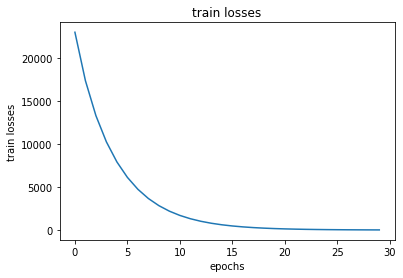

In [37]:
## We plot the train losses

plot_train_losses(loss1.shape[0], loss1, 'Coordinate_descent')

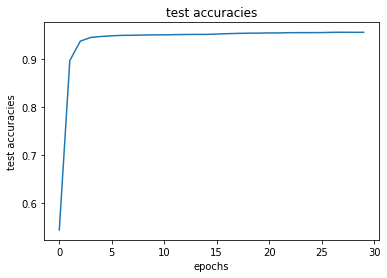

In [38]:
## We plot the test accuracy

plot_test_accuracy(accuracy_test.shape[0], accuracy_test, 'Coordinate_descent')